# Step 1: Exploratory Data Analysis

In [607]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

# read .cvs files
n = sum(1 for line in open('train.csv')) - 1 #number of records in file (excludes header)
s = 10000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
df = pd.read_csv('train.csv', skiprows=skip)

# df = pd.read_csv('train.csv', nrows=5) # nrows=1000
test_df = pd.read_csv('test.csv')

# get target sets
y_train = df["Sentiment"].to_numpy()
y_test = test_df["Sentiment"].to_numpy()

In [608]:
# print descriptive statistics of the data, including mean, standard deviation, median, etc.
basic_info = df.describe()
print(basic_info)

              Index    Sentiment
count  1.000000e+04  10000.00000
mean   5.244702e+05      0.23800
std    3.039874e+05      0.42588
min    1.450000e+02      0.00000
25%    2.601580e+05      0.00000
50%    5.271360e+05      0.00000
75%    7.880028e+05      0.00000
max    1.048513e+06      1.00000


In [609]:
# display the beginning X rows 
print("The data from the first 5 rows are: \n", df.head(5))

# display the bottom X rows 
print("The data from the last 5 rows are: \n", df.tail(5))

The data from the first 5 rows are: 
    Index  Sentiment                                               Text
0    145          0  @twista202 I still haven't read the 9th&amp;10...
1    278          0  My son Vincas is sick, so I stay at home  Just...
2    417          0                ITS NOT ENOUGH TO SAY THAT IMISS U 
3    561          0  sad that the 'feet' of my macbook just fell of...
4    742          0  @djsoulsister yeah, great vid. I had the 12&qu...
The data from the last 5 rows are: 
         Index  Sentiment                                               Text
9995  1047952          1                                       Bye twitter 
9996  1048365          1  @lovebscott b.scott you look amazing in your b...
9997  1048446          1      Going to the mall + movie with good friends. 
9998  1048485          1  @ashleyraebby it's just an awards show. That t...
9999  1048513          1      @SEGA Did my direct message test get to you? 


In [610]:
# check for missing values; verdict = none
df.isna().sum()

Index        0
Sentiment    0
Text         0
dtype: int64

C:\Users\linya\AppData\Local\Temp\ipykernel_27612\1400134019.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df['Sentiment'], palette='bright')


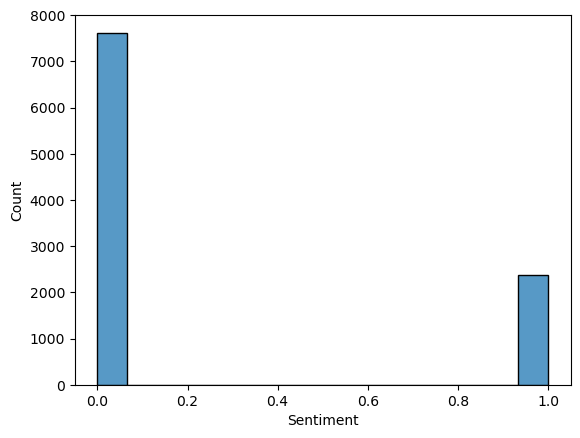

In [611]:
# distribution of negative and positive sentiments
sns.histplot(data=df['Sentiment'], palette='bright')
plt.show()
# much more negative than positive sentiments

# Step 2: Text Preprocessing

In [612]:
import nltk
import contractions
import re

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\linya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\linya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\linya\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [613]:
def tokenize(column):

    # remove '@', 'http', and contractions
    for word in column.split():
      if word.startswith('@'):
        column = column.replace(word, '')
      if word.startswith('http'):
        column = column.replace(word, '')
      if '\'' in word:
        column = column.replace(word, contractions.fix(word))
        # print (word, '->', contractions.fix(word))

    # tokenize, remove punctuation, then stem
    tokens = nltk.word_tokenize(column)
    expanded_tokens = []
    i = 0
    while i < len(tokens):
      # if tokens[i] not in stopwords.words('english'):
      if tokens[i].isalpha():
        expanded_tokens.append(lemmatizer.lemmatize(tokens[i].lower()))
      i += 1

    return expanded_tokens

In [614]:
def join_tokens(column):

    # remove '@', 'http', and contractions
    for word in column.split():
      if word.startswith('@'):
        column = column.replace(word, '')
      if word.startswith('http'):
        column = column.replace(word, '')
      if '\'' in word:
        column = column.replace(word, contractions.fix(word))
        # print (word, '->', contractions.fix(word))

    # tokenize, remove punctuation, then stem
    tokens = nltk.word_tokenize(column)
    expanded_tokens = []
    i = 0
    while i < len(tokens):
      # if tokens[i] not in stopwords.words('english'):
      if tokens[i].isalpha():
        expanded_tokens.append(lemmatizer.lemmatize(tokens[i].lower()))
      i += 1

    return " ".join(expanded_tokens)

In [615]:
df['Tokenized'] = df.apply(lambda x: tokenize(x['Text']), axis=1)
df['Joined Tokens'] = df.apply(lambda x: join_tokens(x['Text']), axis=1)

test_df['Tokenized'] = test_df.apply(lambda x: tokenize(x['Text']), axis=1)
test_df['Joined Tokens'] = test_df.apply(lambda x: join_tokens(x['Text']), axis=1)

df[['Sentiment','Tokenized','Joined Tokens']].tail()

,Sentiment,Tokenized,Joined Tokens
9995,1,"[bye, twitter]",bye twitter
9996,1,"[you, look, amazing, in, your, background, pic...",you look amazing in your background picture ho...
9997,1,"[going, to, the, mall, movie, with, good, friend]",going to the mall movie with good friend
9998,1,"[it, is, just, an, award, show, that, take, pl...",it is just an award show that take place in ob...
9999,1,"[did, my, direct, message, test, get, to, you]",did my direct message test get to you


# Step 3: Linguistic Feature Extraction

In [616]:
# Bag of words model
from sklearn.feature_extraction.text import CountVectorizer

corpus = []
for data in df['Joined Tokens']:
    corpus.append(data)

# Create a Count Vectorizer Object
vectorizer  = CountVectorizer(max_features=1000, ngram_range=(1,2))
bow_vector = vectorizer.fit_transform(corpus)

In [617]:
# TF*IDF model
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = []
for data in df['Joined Tokens']:
    corpus.append(data)

# Create a Tfid Vectorizer Object
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
tfidf_vector = vectorizer.fit_transform(corpus)

In [618]:
# # word2vec/word embedding model
# import gensim
# from gensim.models import Word2Vec

# words = []
# test_words = []

# for data in df['Tokenized']:
#     words.append(data)
# for data in test_df['Tokenized']:
#     test_words.append(data)

# # CBOW model
# cbow = gensim.models.Word2Vec(words, min_count = 1,vector_size = 100, window = 5, sg=0)
# # Skip-gram model
# skipgram = gensim.models.Word2Vec(words, min_count = 1,vector_size = 100, window = 5, sg=1)

# cbow_vector = []
# skipgram_vector = []

# for data in df['Tokenized']:
#     for word in data:
#         cbow_vector.append(cbow.wv[word])
#     # cbow_vector.append(function_text_2_vec(data))

# for data in df['Tokenized']:
#     for word in data:
#         skipgram_vector.append(skipgram.wv[word])

# print(np.array(cbow_vector).mean(axis=0))

In [619]:
# trying something else for w2v
import gensim
from gensim.models import Word2Vec

sentences = [sentence for sentence in df['Joined Tokens']]
w2v_model = Word2Vec(sentences, vector_size=1000, window=5, min_count=5, workers=4)

In [620]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(1000)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)


# Step 4: Build sentiment classification model

In [621]:
# Import classifiers and metrics from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

lc = LogisticRegression()
neigh = KNeighborsClassifier(n_neighbors=3)
svc = SVC(probability=True)
nbc = GaussianNB()
rfc = RandomForestClassifier()


In [622]:
# # SMOTE for Imbalanced Classification
from imblearn.over_sampling import SMOTE

def train_and_predict_models():
    y = df['Sentiment'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    over_sampled_X_train, X_test, over_sampled_y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    oversample = SMOTE()
    over_sampled_X_train, over_sampled_y_train = oversample.fit_resample(X_train, y_train)

    lc.fit(over_sampled_X_train, over_sampled_y_train)
    neigh.fit(over_sampled_X_train, over_sampled_y_train)
    svc.fit(over_sampled_X_train, over_sampled_y_train)
    nbc.fit(over_sampled_X_train, over_sampled_y_train)
    rfc.fit(over_sampled_X_train, over_sampled_y_train)

    y_lc_predicted = lc.predict(X_test)
    y_lc_pred_proba = lc.predict_proba(X_test)

    y_knn_predicted = neigh.predict(X_test)
    y_knn_pred_proba = neigh.predict_proba(X_test)

    y_svc_predicted = svc.predict(X_test)
    y_svc_pred_proba = svc.predict_proba(X_test)

    y_nbc_predicted = nbc.predict(X_test)
    y_nbc_pred_proba = nbc.predict_proba(X_test)

    y_rfc_predicted = rfc.predict(X_test)
    y_rfc_pred_proba = rfc.predict_proba(X_test)

    print('Logistic Regression:\n', classification_report(y_test, y_lc_predicted))
    print('K Nearest Neighbor:\n', classification_report(y_test, y_knn_predicted))
    print('Support Vector Machine:\n', classification_report(y_test, y_svc_predicted))
    print('Naive Bayes Classification:\n', classification_report(y_test, y_nbc_predicted))
    print('Random Forest classification:\n', classification_report(y_test, y_rfc_predicted))

    models = ['Logistic Regression', 'K Nearest Neighbor', 'Support Vector Machine', 'Naive Bayes Classifier', 'Random Forest Classifier']
    predictions = [y_lc_predicted, y_knn_predicted, y_svc_predicted, y_nbc_predicted, y_rfc_predicted]
    pred_probabilities = [y_lc_pred_proba, y_knn_pred_proba, y_svc_pred_proba, y_nbc_pred_proba, y_rfc_pred_proba]

    plot = 1

    for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
        disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
        disp.plot(
            include_values=True,
            cmap='gray',
            colorbar=False
        )
        disp.ax_.set_title(f"{model} Confusion Matrix")

    plt.figure(figsize=(30, 15))
    plt.suptitle("ROC Curves")
    plot_index = 1

    for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
        fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
        auc_score = auc(fpr, tpr)
        plt.subplot(3, 2, plot_index)
        plt.plot(fpr, tpr, 'r', label='ROC curve')
        # pyplot.figure(figsize=(5, 5))
        plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
        plt.xlabel('FPR', fontsize=12)
        plt.ylabel('TPR', fontsize=12)
        plt.legend()
        plot_index += 1
    plt.show()

Bag of Words: 



c:\Users\linya\anaconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression:
               precision    recall  f1-score   support

           0       0.87      0.79      0.83      1527
           1       0.48      0.63      0.55       473

    accuracy                           0.75      2000
   macro avg       0.68      0.71      0.69      2000
weighted avg       0.78      0.75      0.76      2000

K Nearest Neighbor:
               precision    recall  f1-score   support

           0       0.83      0.55      0.67      1527
           1       0.31      0.64      0.42       473

    accuracy                           0.57      2000
   macro avg       0.57      0.60      0.54      2000
weighted avg       0.71      0.57      0.61      2000

Support Vector Machine:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      1527
           1       0.52      0.44      0.47       473

    accuracy                           0.77      2000
   macro avg       0.67      0.65      0.66      2000
weight

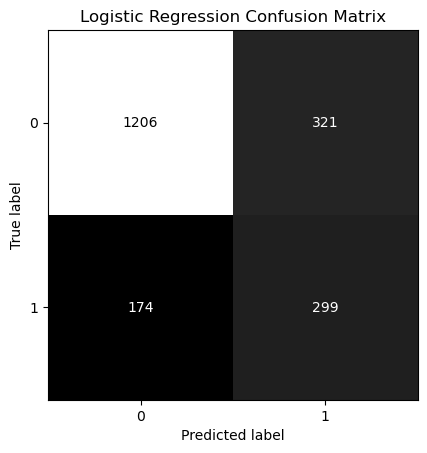

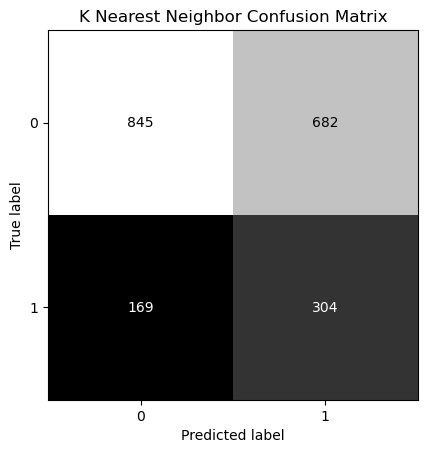

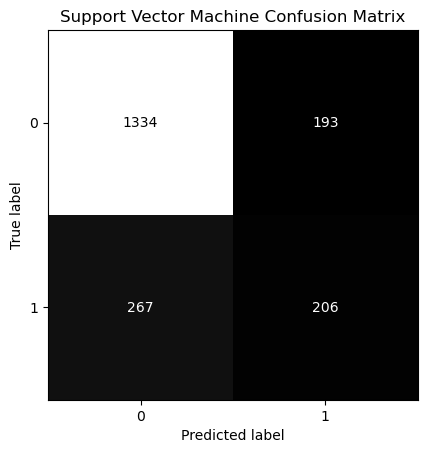

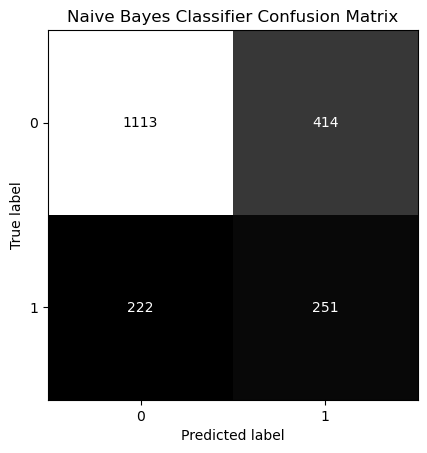

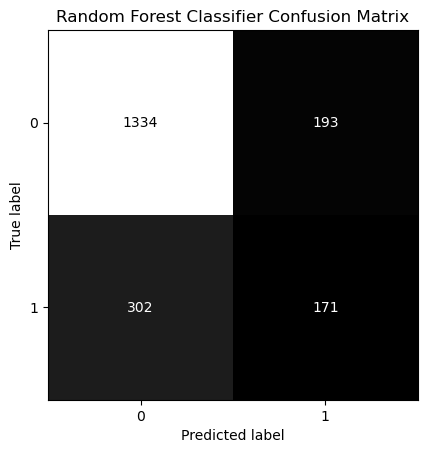

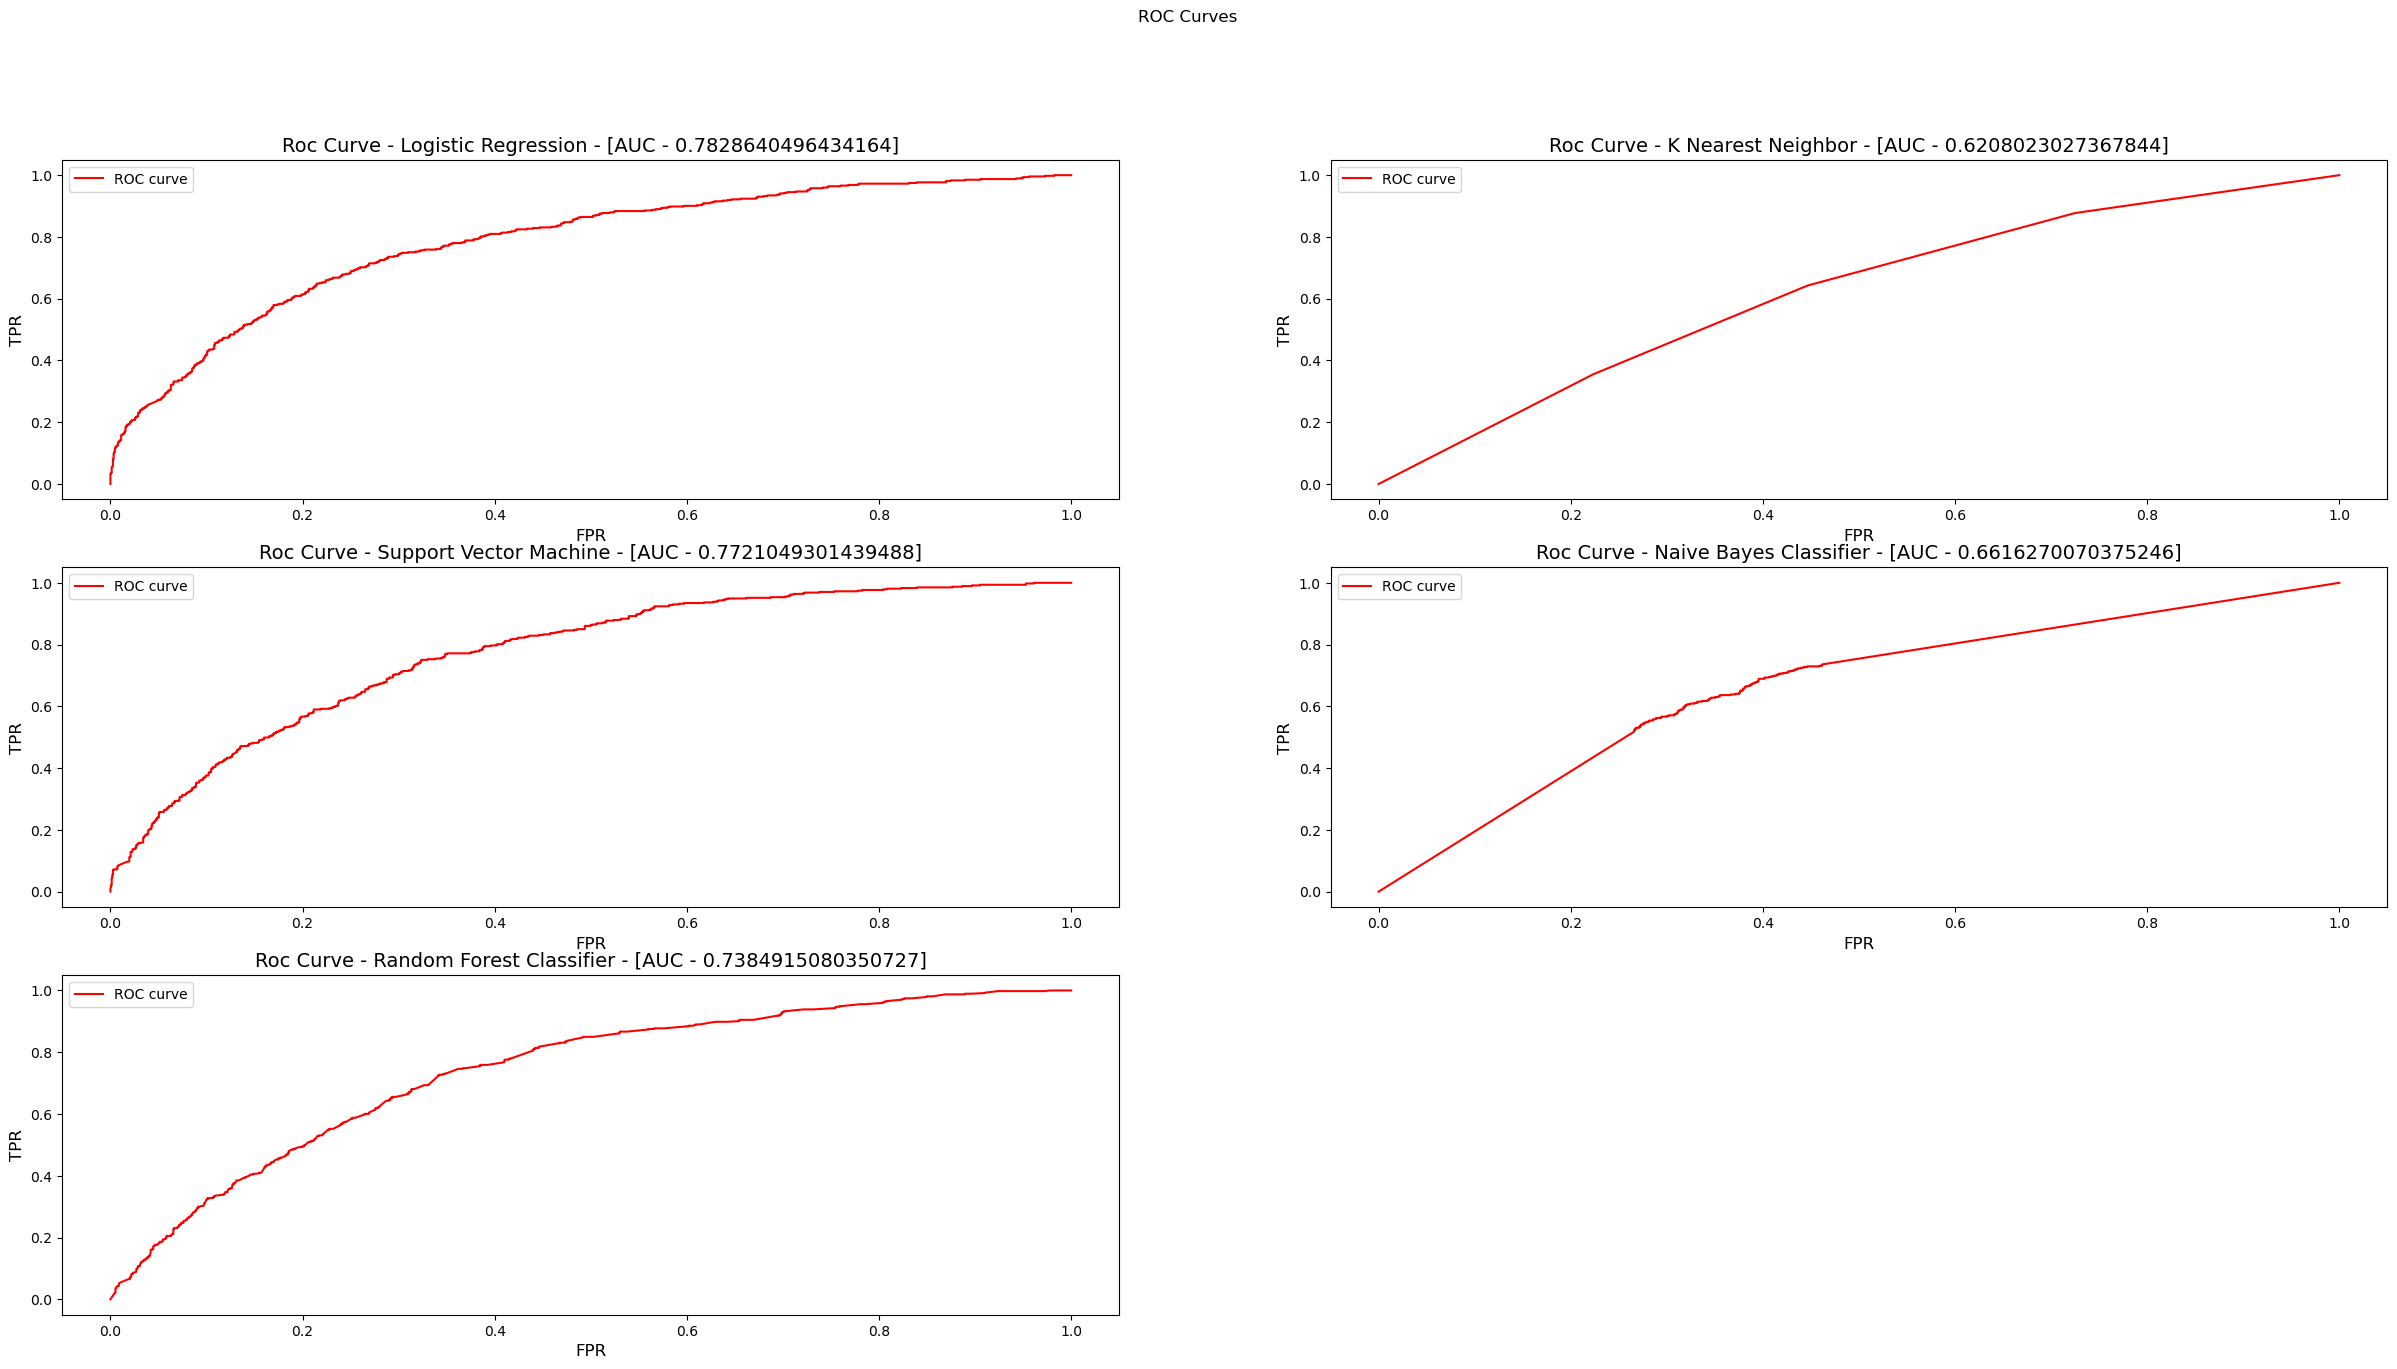

TF*IDF: 

Logistic Regression:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83      1527
           1       0.49      0.64      0.55       473

    accuracy                           0.76      2000
   macro avg       0.68      0.72      0.69      2000
weighted avg       0.79      0.76      0.77      2000

K Nearest Neighbor:
               precision    recall  f1-score   support

           0       0.84      0.18      0.30      1527
           1       0.25      0.89      0.39       473

    accuracy                           0.35      2000
   macro avg       0.55      0.54      0.35      2000
weighted avg       0.70      0.35      0.32      2000

Support Vector Machine:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87      1527
           1       0.62      0.31      0.41       473

    accuracy                           0.79      2000
   macro avg       0.71      0.63      0.64      2

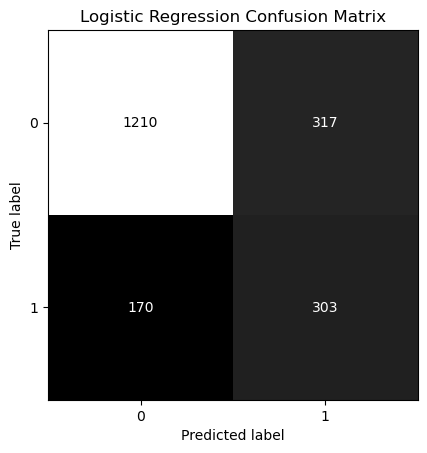

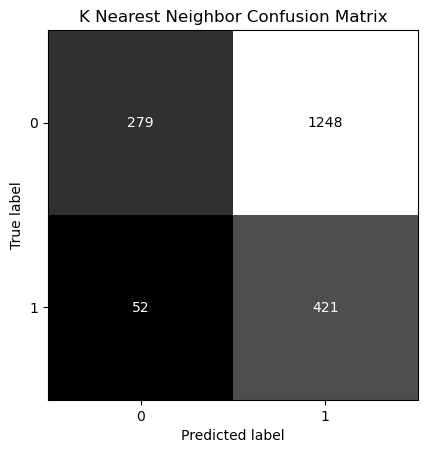

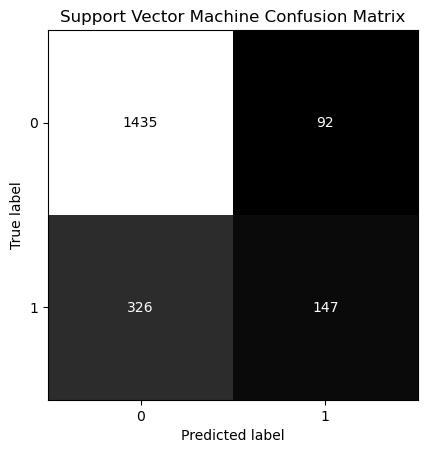

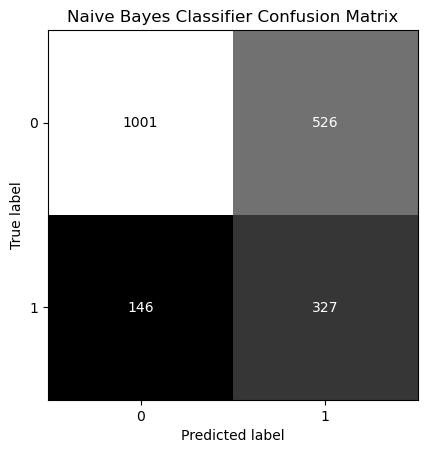

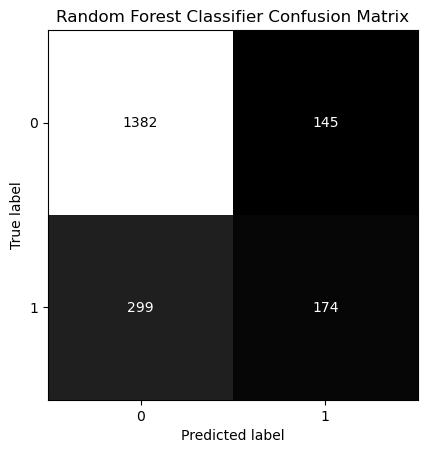

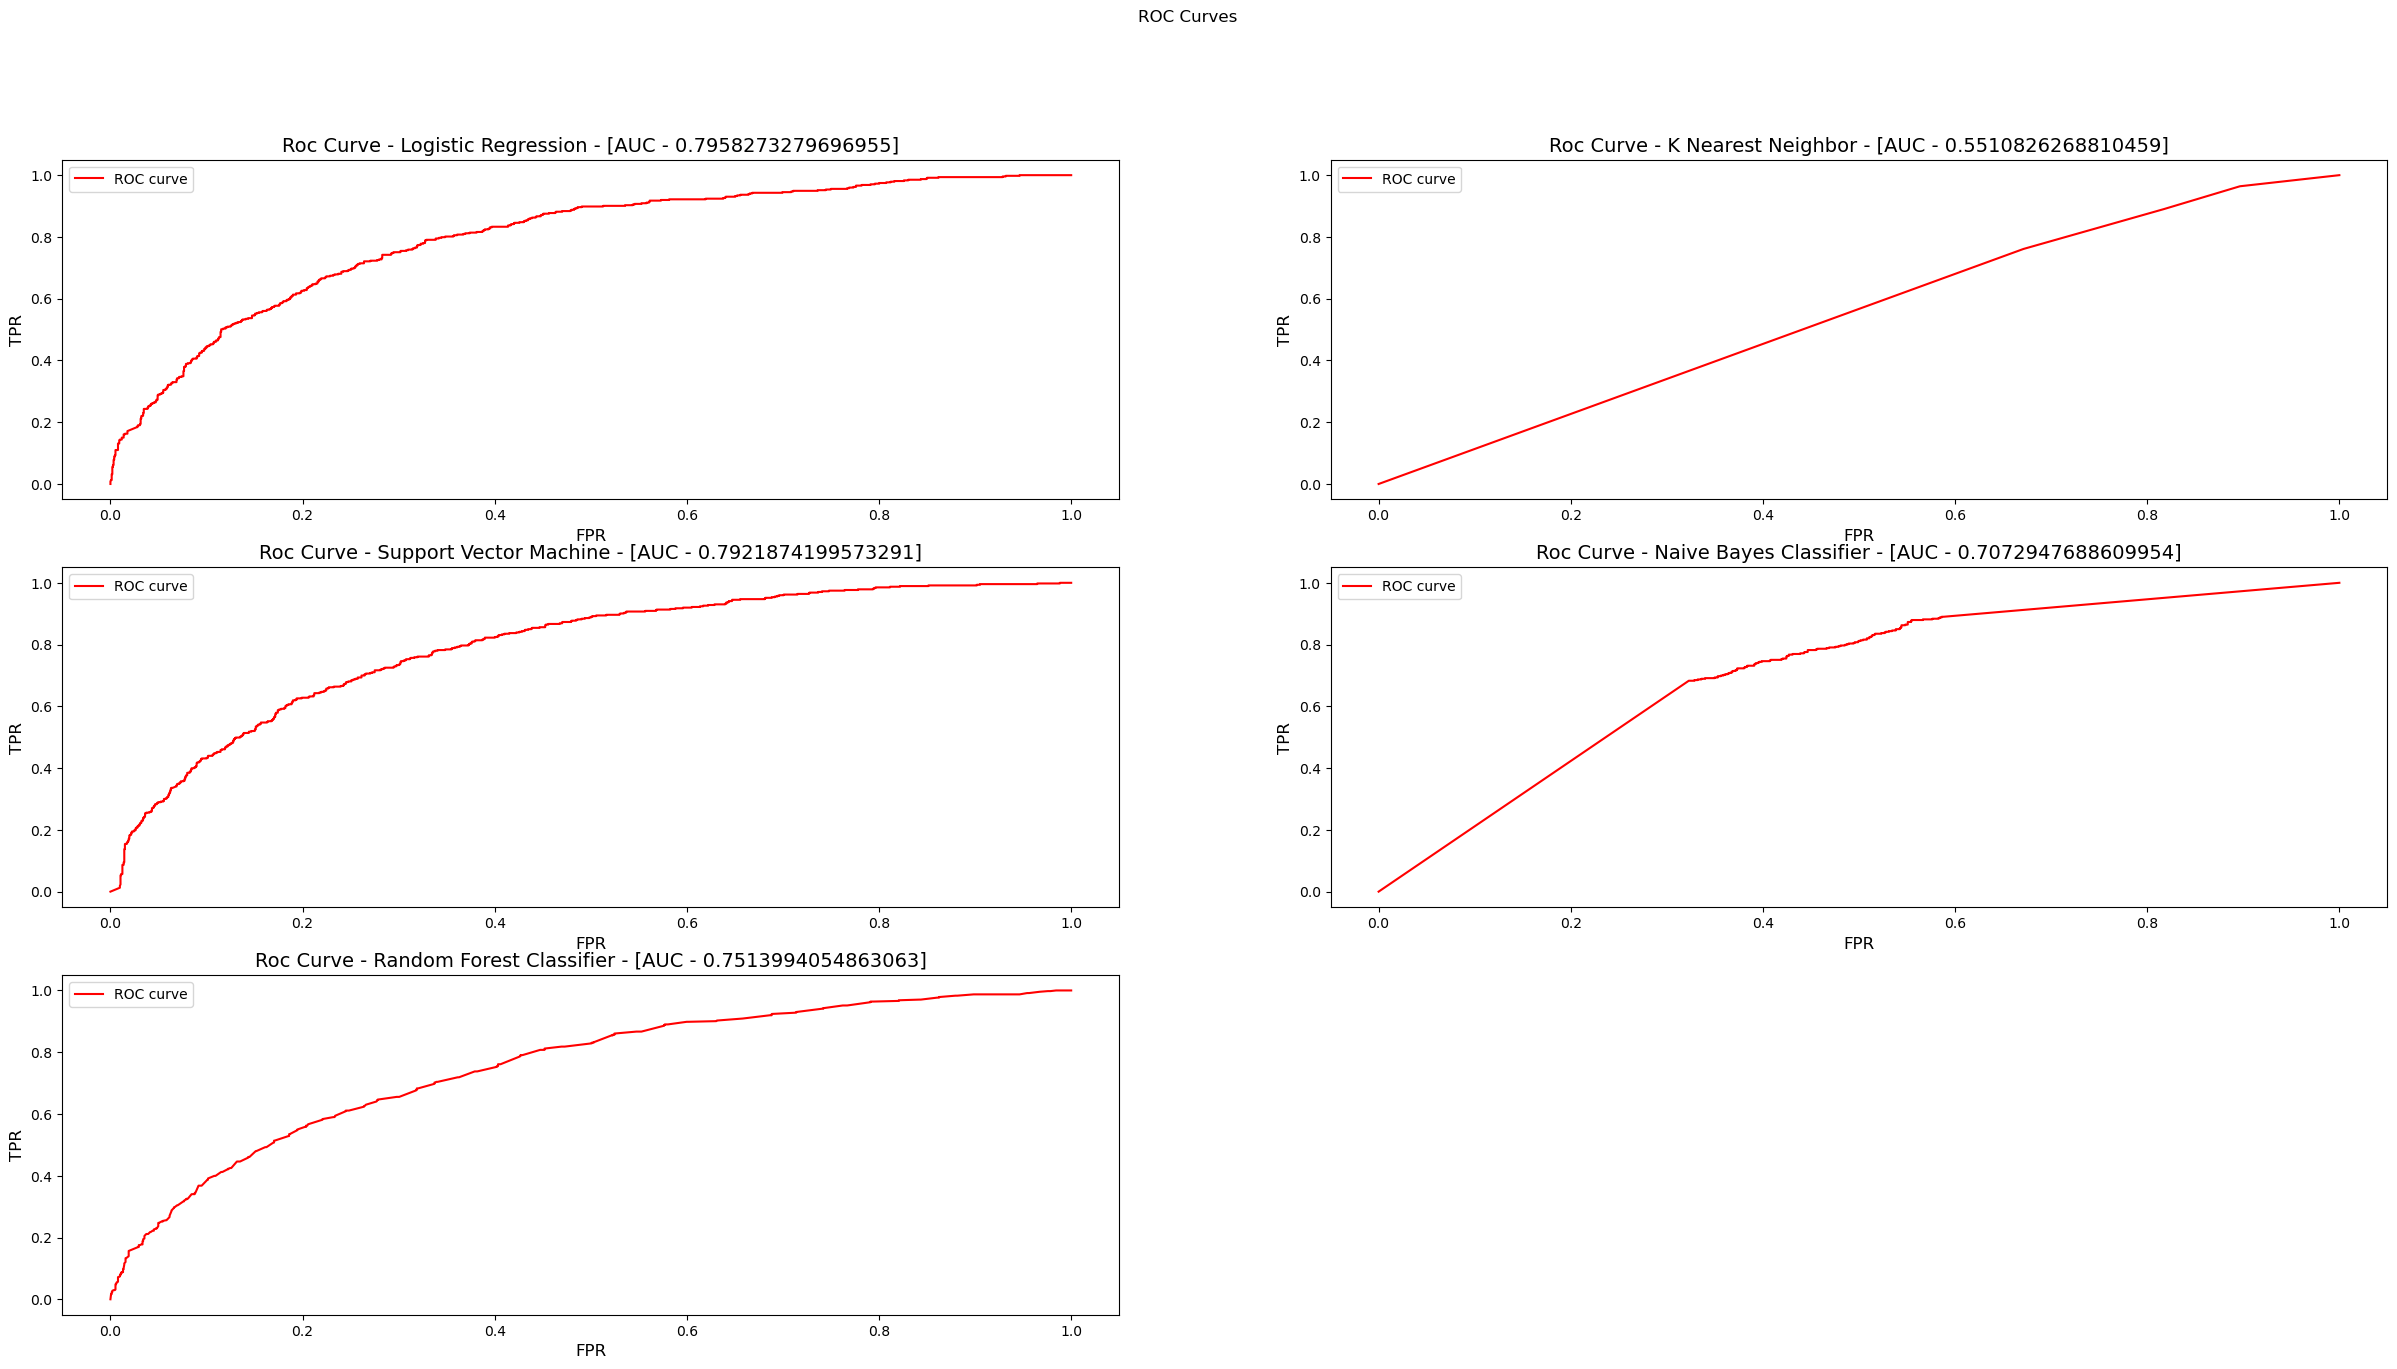

Word2Vec: 



c:\Users\linya\anaconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression:
               precision    recall  f1-score   support

           0       0.83      0.49      0.62      1527
           1       0.29      0.67      0.41       473

    accuracy                           0.54      2000
   macro avg       0.56      0.58      0.51      2000
weighted avg       0.70      0.54      0.57      2000

K Nearest Neighbor:
               precision    recall  f1-score   support

           0       0.74      0.54      0.62      1527
           1       0.21      0.39      0.27       473

    accuracy                           0.50      2000
   macro avg       0.47      0.46      0.45      2000
weighted avg       0.61      0.50      0.54      2000

Support Vector Machine:
               precision    recall  f1-score   support

           0       0.83      0.51      0.63      1527
           1       0.29      0.65      0.40       473

    accuracy                           0.55      2000
   macro avg       0.56      0.58      0.52      2000
weight

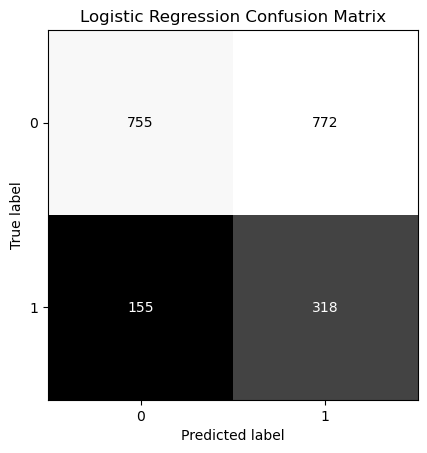

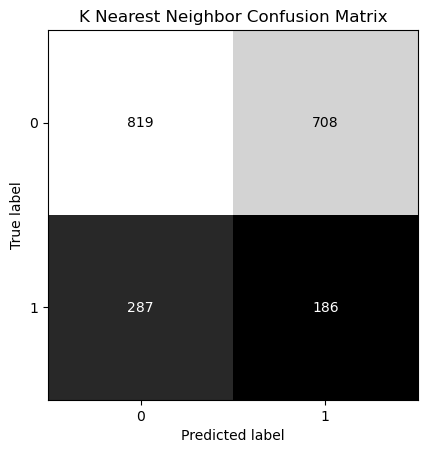

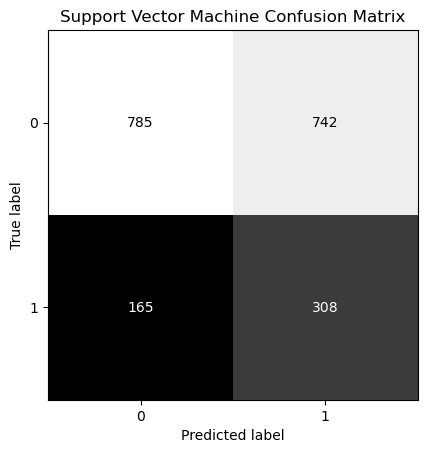

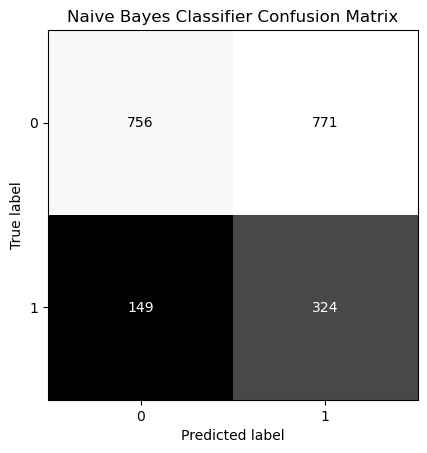

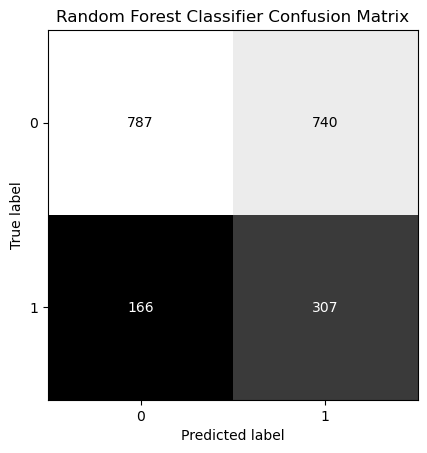

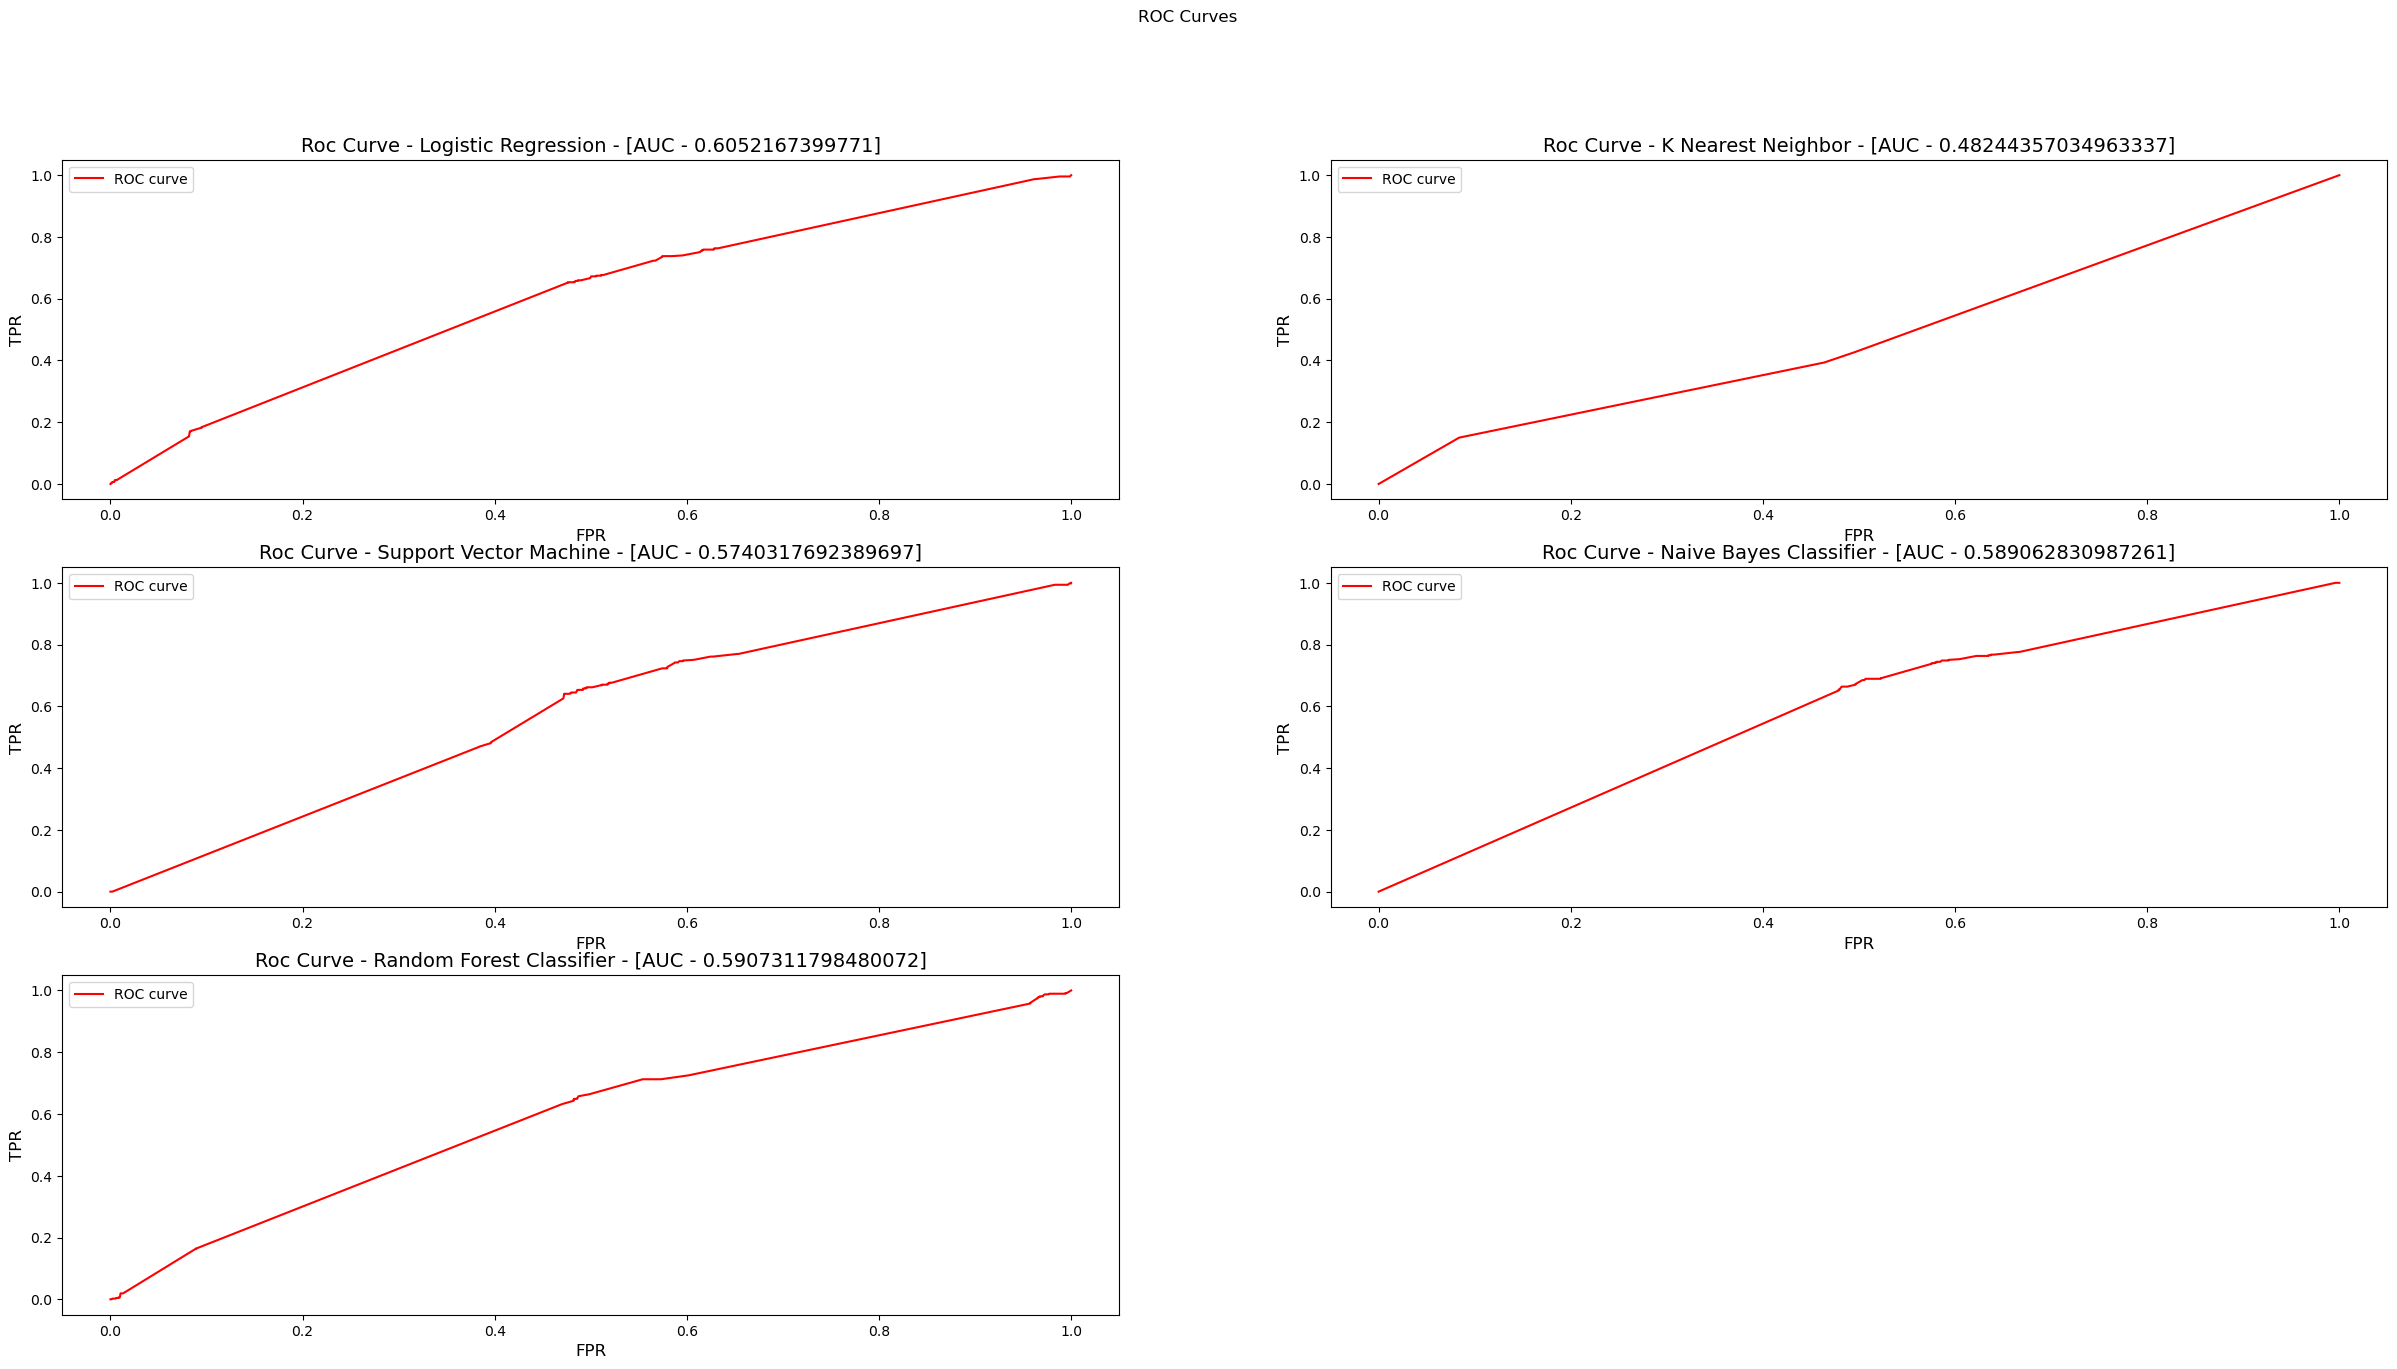

In [623]:
# Bag of Words
print('Bag of Words: \n')
X = bow_vector.toarray()
train_and_predict_models()

# TF*IDF
print('TF*IDF: \n')
X = tfidf_vector.toarray()
train_and_predict_models()

# Word2Vec
print('Word2Vec: \n')
# X = np.array(cbow_vector)
# train_and_predict_models()
X = np.array([vectorize(sentence) for sentence in df['Joined Tokens']])
train_and_predict_models()
